In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup

In [265]:
def chart(stock_name):
    #Load the Data
    df = pd.read_csv('{}.csv'.format(stock_name))
    new_information = pd.read_csv('{}.csv'.format(stock_name))

    # Now that we saved our chart, we can copy our code to retrieve the daily information we do not have
    # This cell's code has already been written above in seperate cells. This cell condenses the retreival process.
    page = requests.get('https://finance.yahoo.com/quote/{}/history?p={}'.format(stock_name, stock_name))
    soup = BeautifulSoup(page.content, 'html.parser')
    info = soup.find('table', class_ = 'W(100%) M(0)')
    columns = info.find_all('td')

    # First new date
    new_date = str(columns[0])
    new_date = new_date[-24:-12]
    new_open_price = str(columns[1])
    new_open_price = new_open_price[-18:-12].strip('>')
    new_open_price = float(new_open_price)
    new_adj_close_price = str(columns[5])
    new_adj_close_price = new_adj_close_price[-18:-12].strip('>')
    new_adj_close_price = float(new_adj_close_price)

    # Second Date
    second_date = str(columns[7])
    second_date = second_date[-24:-12]
    second_open_price = str(columns[8])
    second_open_price = second_open_price[-18:-12].strip('>')
    second_open_price = float(second_open_price)
    second_adj_close_price = str(columns[12])
    second_adj_close_price = second_adj_close_price[-18:-12].strip('>')
    second_adj_close_price = float(second_adj_close_price)

    # Third Date
    third_date = str(columns[14])
    third_date = third_date[-24:-12]
    third_open_price = str(columns[15])
    third_open_price = third_open_price[-18:-12].strip('>')
    third_open_price = float(third_open_price)
    third_adj_close_price = str(columns[19])
    third_adj_close_price = third_adj_close_price[-18:-12].strip('>')
    third_adj_close_price = float(third_adj_close_price)

    # Fouth Date
    fourth_date = str(columns[21])
    fourth_date = fourth_date[-24:-12]
    fourth_open_price = str(columns[22])
    fourth_open_price = fourth_open_price[-18:-12].strip('>')
    fourth_open_price = float(fourth_open_price)
    fourth_adj_close_price = str(columns[26])
    fourth_adj_close_price = fourth_adj_close_price[-18:-12].strip('>')
    fourth_adj_close_price = float(fourth_adj_close_price)

    # Fifth Date
    fifth_date = str(columns[28])
    fifth_date = fifth_date[-24:-12]
    fifth_open_price = str(columns[29])
    fifth_open_price = fifth_open_price[-18:-12].strip('>')
    fifth_open_price = float(fifth_open_price)
    fifth_adj_close_price = str(columns[33])
    fifth_adj_close_price = fifth_adj_close_price[-18:-12].strip('>')
    fifth_adj_close_price = float(fifth_adj_close_price)

    column_info = {'Date':[new_date, second_date, third_date, fourth_date, fifth_date],
            'Open':[new_open_price, second_open_price, third_open_price, fourth_open_price, fifth_open_price],
            'Adj Close':[new_adj_close_price, second_adj_close_price, third_adj_close_price, fourth_adj_close_price, fifth_adj_close_price]}

    new_information = pd.DataFrame(data = column_info)
    new_information['Open'] = new_information['Open']
    new_information['Adj Close'] = new_information['Adj Close']
    new_information['Date'] = pd.to_datetime(new_information.Date)
    df['Date'] = pd.to_datetime(df.Date)
    
    combined = pd.concat([df, new_information], sort = True)
    combined.sort_values(by = 'Date', inplace = True)
    combined.reset_index(drop = True, inplace = True)
    combined.drop_duplicates(subset = ['Date'], inplace = True)
    
    updated_info = combined.to_csv('{}.csv'.format(stock_name), index = False)

    #Create a simple moving average with a 30 day window
    SMA_30 = pd.DataFrame()
    SMA_30['Adj_Close_Price'] = combined['Adj Close'].rolling(window = 30).mean()
    SMA_30

    # Short moving average for 100 days
    SMA_100 = pd.DataFrame()
    SMA_100['Adj_close_price'] = combined['Adj Close'].rolling(window = 100).mean()
    SMA_100

    # Create a dataframe of all adj close prices
    data = pd.DataFrame()
    data['Date'] = combined['Date']
    data['AAL_adj_close'] = combined['Adj Close']
    data['SMA_30'] = SMA_30['Adj_Close_Price']
    data['SMA_100']= SMA_100['Adj_close_price']

    #Create a Function to signal when to buy and sell
    def buy_sell(data):
        sig_price_buy = []
        sig_price_sell = []
        flag = -1

        for i in range(len(data)):
            if data['SMA_30'][i] > data['SMA_100'][i]:
                if flag != 1:
                    sig_price_buy.append(data['AAL_adj_close'][i])
                    sig_price_sell.append(np.nan)
                    flag = 1
                else:
                    sig_price_buy.append(np.nan)
                    sig_price_sell.append(np.nan)
            elif data['SMA_30'][i] < data['SMA_100'][i]:
                if flag !=0:
                    sig_price_buy.append(np.nan)
                    sig_price_sell.append(data['AAL_adj_close'][i])
                    flag = 0
                else:
                    sig_price_buy.append(np.nan)
                    sig_price_sell.append(np.nan)
            else:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(np.nan)

        return (sig_price_buy, sig_price_sell)

    #store the buy and sell data into a variable
    buy_sell = buy_sell(data)
    data['buy_signal_price'] = buy_sell[0]
    data['sell_signal_price']=buy_sell[1]

    #Looking for the dates of the buy signals
    buy_dates = combined.loc[data['buy_signal_price']>0]

    #Looking for the dates of the sell signals
    sell_dates = combined.loc[data['sell_signal_price']>0]


    # DF of dates with prices
    dates = pd.concat([buy_dates, sell_dates],sort = True)

    # Now to organize by the dates, drop adj_close price column, and make date the index
    dates.sort_values(by = 'Date', inplace = True)
    dates.set_index('Date', inplace = True)

    #visualize data and strategy to buy and sell stock
    ab = plt.figure(figsize=(12,8))
    combined.Date = pd.to_datetime(combined.Date).dt.strftime('%b %d %Y')
    last_date = combined['Date'].iloc[-1]
    plt.plot(data['AAL_adj_close'],label = 'PMAC', alpha = 0.35)
    plt.plot(data['SMA_30'], label = 'SMA30', alpha = 0.35)
    plt.plot(data['SMA_100'],label = 'SMA100', alpha = 0.35)
    plt.scatter(data.index, data['buy_signal_price'],label = 'Buy',marker = '^', color = 'green')
    plt.scatter(data.index, data['sell_signal_price'], label = 'Sell', marker = 'v', color = 'red')
    plt.title('{} adj close price history buy and sell signals'.format(x))
    plt.xlabel('Aug 19, 2015 - {}'.format(last_date))
    plt.ylabel('Adj close price USD')
    plt.legend()
    plt.show()
    print(dates)

    return dates



 AAPL


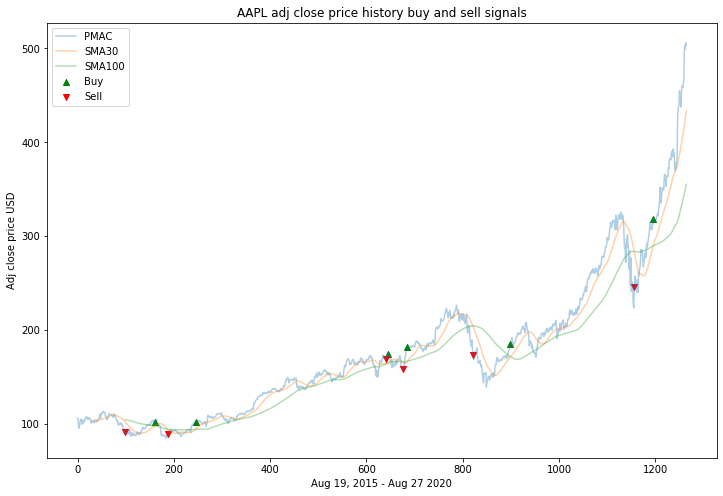

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2016-01-11,91.442703,98.529999,99.059998,97.339996,98.970001,49739400.0
2016-04-08,101.391273,108.660004,109.769997,108.169998,108.910004,23581700.0
2016-05-18,88.771683,94.559998,95.209999,93.889999,94.160004,42062400.0
2016-08-10,101.938248,108.000000,108.900002,107.760002,108.709999,24008500.0
2018-03-07,169.412445,175.029999,175.850006,174.270004,174.940002,31703500.0
2018-03-13,174.193893,179.970001,183.500000,179.240005,182.589996,31693500.0
2018-04-25,158.397659,163.649994,165.419998,162.410004,162.619995,28382100.0
2018-05-09,181.346710,187.360001,187.399994,185.220001,186.550003,23211200.0
2018-11-20,173.165588,176.979996,181.470001,175.509995,178.369995,67825200.0


In [262]:
print('Enter Stock: ')
x = input()
chart('{}'.format(x))

In [162]:
def new_info(data):
    
        # Now that we saved our chart, we can copy our code to retrieve the daily information we do not have
        # This cell's code has already been written above in seperate cells. This cell condenses the retreival process.
        page = requests.get('https://finance.yahoo.com/quote/AAPL/history?p={}'.format(data))
        soup = BeautifulSoup(page.content, 'html.parser')
        info = soup.find('table', class_ = 'W(100%) M(0)')
        columns = info.find_all('td')

        # First new date
        new_date = str(columns[0])
        new_date = new_date[-24:-12]
        new_open_price = str(columns[1])
        new_open_price = new_open_price[-18:-12]
        new_open_price = float(new_open_price)
        new_adj_close_price = str(columns[5])
        new_adj_close_price = new_adj_close_price[-18:-12]
        new_adj_close_price = float(new_adj_close_price)

        # Second Date
        second_date = str(columns[7])
        second_date = second_date[-24:-12]
        second_open_price = str(columns[8])
        second_open_price = second_open_price[-18:-12]
        second_open_price = float(second_open_price)
        second_adj_close_price = str(columns[12])
        second_adj_close_price = second_adj_close_price[-18:-12]
        second_adj_close_price = float(second_adj_close_price)

        # Third Date
        third_date = str(columns[14])
        third_date = third_date[-24:-12]
        third_open_price = str(columns[15])
        third_open_price = third_open_price[-18:-12]
        third_open_price = float(third_open_price)
        third_adj_close_price = str(columns[19])
        third_adj_close_price = third_adj_close_price[-18:-12]
        third_adj_close_price = float(third_adj_close_price)

        # Fouth Date
        fourth_date = str(columns[21])
        fourth_date = fourth_date[-24:-12]
        fourth_open_price = str(columns[22])
        fourth_open_price = fourth_open_price[-18:-12]
        fourth_open_price = float(fourth_open_price)
        fourth_adj_close_price = str(columns[26])
        fourth_adj_close_price = fourth_adj_close_price[-18:-12]
        fourth_adj_close_price = float(fourth_adj_close_price)

        # Fifth Date
        fifth_date = str(columns[28])
        fifth_date = fifth_date[-24:-12]
        fifth_open_price = str(columns[29])
        fifth_open_price = fifth_open_price[-18:-12]
        fifth_open_price = float(fifth_open_price)
        fifth_adj_close_price = str(columns[33])
        fifth_adj_close_price = fifth_adj_close_price[-18:-12]
        fifth_adj_close_price = float(fifth_adj_close_price)

        column_info = {'Date':[new_date, second_date, third_date, fourth_date, fifth_date],
                'Open':[new_open_price, second_open_price, third_open_price, fourth_open_price, fifth_open_price],
                'Adj Close':[new_adj_close_price, second_adj_close_price, third_adj_close_price, fourth_adj_close_price, fifth_adj_close_price]}

        new_information = pd.DataFrame(data = column_info)
        new_information['Date'] = pd.to_datetime(new_information.Date)


        df['Date'] = pd.to_datetime(df.Date)
        combined = pd.concat([df, new_information], sort = True)
        combined.sort_values(by = 'Date', inplace = True)
        combined.reset_index(drop = True, inplace = True)
        combined.drop_duplicates(subset = ['Date'], inplace = True)
        combined.tail(10)

        #Let's change the order of our columns so it's more legilble
        combined = combined[['Date', 'Open', 'Adj Close']]
        
        return combined